[課題のURL](https://diver.diveintocode.jp/curriculums/1435)

# Sprint 機械学習スクラッチSVM

In [237]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 【問題1】ラグランジュの未定乗数法による最急降下

# 最急降下法

SVMの最適化問題は、ラグランジュの未定乗数法により解くことができます。  
サンプル数分のラグランジュ乗数 λを用意して、以下の式により更新していきます。  

$\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})$

ここで k(xi, xj)はカーネル関数です。
線形カーネルの場合は次のようになります。  
他のカーネル関数にも対応できるように、この部分はメソッド化しておきましょう。  

$k(x_i, x_j) = x_{i}^{T} x_j$

~~~
def _kernel(self, X1, X2):
        """
        カーネル関数

        Parameters
        ----------
        X1 : 次の形のndarray, shape (n_samples, n_features)
            ****
        X2 : 次の形のndarray, shape (n_samples, n_features)
            ****
            
        Returns
        -------
            次の形のndarray, shape (n_samples, n_samples)
            ****
        """
        
        return np.dot(X2, X1.T)
    
def _gradient_descent(self, k, yy, lam):
        """
        最急降下法により、lambdaの値を求める
        
        Parameters
        ----------
        X1 : 次の形のndarray, k (n_samples, n_samples)
            カーネル関数の値(Xi*Xj)
        y1 : 次の形のndarray, yy (n_samples, n_samples)
            Yi*Yj
        """
        alpha = self.lr
                
        lam = lam + alpha*(1 - np.dot(lam, k*yy))
        #lam = lam + alpha*(1 - y*(np.dot(k, lam*y)))
        
        # 更新毎に lambda_i >= 0 を満たす必要ある
        # このため0でクリップする
        lam[lam < 0.0] = 0.0
        
        return lam
~~~

# 【問題2】サポートベクターの決定

計算したラグランジュ乗数 $\lambda$ が設定した閾値より大きいサンプルをサポートベクターとして扱います。  
推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。  
  
閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。  

~~~
        for _itr in range(num_iter):
            lam = self._gradient_descent(k, yy, lam)
            
            # サポートベクターの決定
            index_sv = np.where(lam > threshold)
            count_sv = len(index_sv[0])
            
            if self.verbose:
            #verboseをTrueにした際は学習過程を出力
                print(count_sv)
        
        # データ保存
        self.n_support_vectors = count_sv
        self.index_support_vectors = index_sv[0]
        self.X_sv = X[index_sv[0]]
        self.y_sv = y[index_sv[0]]
        self.lam_sv = lam[index_sv[0]]
~~~

# 【問題3】推定

推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。  
求めた $f(x)$ の符号が分類結果です。  

$f(x) = \sum_{n=1}^{N}\lambda_n y_{sv\_n} k(x, s_n)$

~~~
    
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        X_sv = self.X_sv
        y_sv = self.y_sv
        lam_sv = self.lam_sv
        
        k = self._kernel(X, X_sv)
        y_pred = np.dot(k.T*y_sv, lam_sv)
        
        return np.sign(y_pred)
~~~

# 【問題4】学習と推定

機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。

In [172]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

scikit-learnによる実装と比べ、正しく動いているかを確認してください。    

学習結果と【問題5】により正しく動作できていることを確認した。  
サポートベクター数が異なるのは、  
恐らく、スクラッチの方は"tol:Tolerance for stopping criterion."  
に対応していないからだと思われる。

In [160]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
    
    def _kernel(self, X1, X2):
        """
        カーネル関数

        Parameters
        ----------
        X1 : 次の形のndarray, shape (n_samples, n_features)
            ****
        X2 : 次の形のndarray, shape (n_samples, n_features)
            ****
            
        Returns
        -------
            次の形のndarray, shape (n_samples, n_samples)
            ****
        """
        
        return np.dot(X2, X1.T)
    
    def _gradient_descent(self, k, yy, lam):
        """
        最急降下法により、lambdaの値を求める
        
        Parameters
        ----------
        X1 : 次の形のndarray, k (n_samples, n_samples)
            カーネル関数の値(Xi*Xj)
        y1 : 次の形のndarray, yy (n_samples, n_samples)
            Yi*Yj
        """
        alpha = self.lr
                
        lam = lam + alpha*(1 - np.dot(lam, k*yy))
        #lam = lam + alpha*(1 - y*(np.dot(k, lam*y)))
        
        # 更新毎に lambda_i >= 0 を満たす必要ある
        # このため0でクリップする
        lam[lam < 0.0] = 0.0
        
        return lam
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        # 検証データ(X_val, y_val)の有無を確認
        flag_val = True
        if (X_val is None) and (y_val is None):
            # 検証データが入力されなかった場合、検証データの保存と学習過程を表示しない
            flag_val = False
        
        # 内部変数の初期化
        alpha = self.lr
        itera = self.iter
        num_iter = self.iter
        threshold = self.threshold
        
        np.random.seed(1)
        lam = np.random.randn(X.shape[0])
        
        _debug_list_count_sv = np.zeros(num_iter)
        _debug_list_count = np.zeros(num_iter)
        
        # @@@暫定
        # 本来は、_gradient_descentの内部で実施したい
        # グラム行列?をfor文のたびに実施すると処理が重いので、
        # 事前(for文実施前)にyi*yjを求める。
        
        # yi*yj(グラム行列?)を作成
        for i in range(y.shape[0]):
            for j in range(y.shape[0]):
                yy[i,j] = y[i]*y[j]
        
        # for文の外で実施する
        k = self._kernel(X, X)
        
        for _itr in range(num_iter):
            lam = self._gradient_descent(k, yy, lam)
            
            # サポートベクターの決定
            index_sv = np.where(lam > threshold)
            count_sv = len(index_sv[0])
            
            _debug_list_count[_itr] = _itr
            _debug_list_count_sv[_itr] = count_sv
            
            if self.verbose:
            #verboseをTrueにした際は学習過程を出力
                print(count_sv)
        
        # データ保存
        self.n_support_vectors = count_sv
        self.index_support_vectors = index_sv[0]
        self.X_sv = X[index_sv[0]]
        self.y_sv = y[index_sv[0]]
        self.lam_sv = lam[index_sv[0]]
        
        self._debug_list_count = _debug_list_count
        self._debug_list_count_sv = _debug_list_count_sv
        
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        X_sv = self.X_sv
        y_sv = self.y_sv
        lam_sv = self.lam_sv
        
        k = self._kernel(X, X_sv)
        y_pred = np.dot(k.T*y_sv, lam_sv)
        
        return np.sign(y_pred)


In [232]:
clf_sc = ScratchSVMClassifier(num_iter=1000, lr=0.001, threshold=1e-5, verbose=0)
clf_sc.fit(X_train, y_train)

print(clf_sc.index_support_vectors)
print(clf_sc.n_support_vectors)

[ 43 126 220 239 284 339]
6


In [235]:
y_pred = clf_sc.predict(X_test)
y_pred

array([-1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,
        1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,
        1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
       -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,
        1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,
        1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,
       -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,
        1., -1.,  1.,  1., -1., -1., -1., -1.])

In [186]:
print("Accuracy（正解率）", accuracy_score(y_test, y_pred))
print("Precision（適合率）", precision_score(y_test, y_pred))
print("Recall（再現率）", recall_score(y_test, y_pred))
print("F値",f1_score(y_test, y_pred))

Accuracy（正解率） 1.0
Precision（適合率） 1.0
Recall（再現率） 1.0
F値 1.0


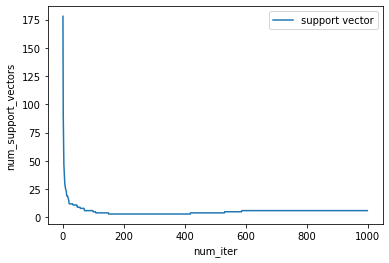

In [187]:
plt.plot(clf_sc._debug_list_count, clf_sc._debug_list_count_sv, label='support vector')
plt.legend()

plt.xlabel("num_iter")
plt.ylabel("num_support_vectors")

# Visualize
plt.show()


# Scikit-learnによる実装

In [231]:
# SVM
from sklearn.svm import SVC

# C=1e10
clf = SVC(C=1, kernel="linear", verbose=True, random_state=1)

clf.fit(X_train, y_train.reshape(375,))
y_pred = clf.predict(X_test)

print(y_pred)

print("Accuracy（正解率）", accuracy_score(y_test, y_pred))
print("Precision（適合率）", precision_score(y_test, y_pred))
print("Recall（再現率）", recall_score(y_test, y_pred))
print("F値",f1_score(y_test, y_pred))

#list_score_svc = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred) ]
#print(list_score_svc)

print(clf.get_params)
print(clf.support_)
#print(clf.support_vectors_)

[LibSVM][-1  1  1 -1 -1  1  1 -1 -1  1 -1  1 -1 -1 -1  1  1  1  1  1 -1 -1  1  1
 -1  1  1  1  1 -1 -1  1  1 -1  1 -1  1 -1 -1  1 -1  1 -1  1 -1  1 -1  1
 -1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1  1 -1 -1 -1 -1  1  1  1
  1  1  1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1  1  1  1 -1  1 -1  1 -1  1
  1  1 -1  1 -1  1  1  1 -1  1 -1  1  1  1  1 -1  1 -1  1 -1  1  1 -1  1
  1 -1 -1 -1 -1]
Accuracy（正解率） 1.0
Precision（適合率） 1.0
Recall（再現率） 1.0
F値 1.0
<bound method BaseEstimator.get_params of SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=True)>
[220 237 126]


# 【問題5】決定領域の可視化

決定領域を可視化してください。

以下の例のようにサポートベクターは異なる色で示してください。

In [210]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    
    # サポートベクター
    XX = X[:,0]
    YY = X[:,1]
    
    x_sv = XX[model.index_support_vectors]
    y_sv = YY[model.index_support_vectors]

    # 散布図を描画
    plt.scatter(x_sv, y_sv, c="y", marker='o')
    
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

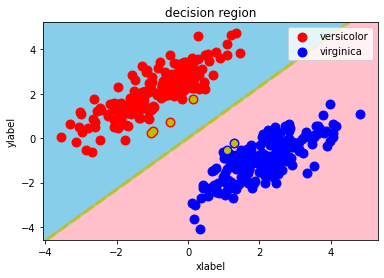

In [211]:
decision_region(X_train, y_train, clf_sc, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica'])

# Scikit-learnによる実装

In [228]:
def decision_region2(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    
    # サポートベクター
    XX = X[:,0]
    YY = X[:,1]
    
    x_sv = XX[model.support_]
    y_sv = YY[model.support_]

    # 散布図を描画
    plt.scatter(x_sv, y_sv, c="y", marker='o')
    
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

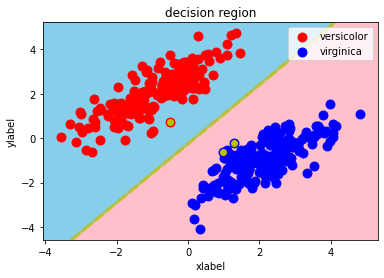

In [230]:
decision_region2(X_train, y_train, clf, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica'])